In [1]:
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

/Users/manshanlin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

In [4]:
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle

In [5]:
from nltk.corpus import stopwords

In [6]:
stop = stopwords.words('english')

In [12]:
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

TRAIN_SIZE=0.8

In [172]:
df=pd.read_csv('train_100000.csv')

In [173]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [174]:
df.sentiment = df.sentiment.apply(lambda x: decode_sentiment(x))

Text(0.5,1,'Dataset labels distribuition')

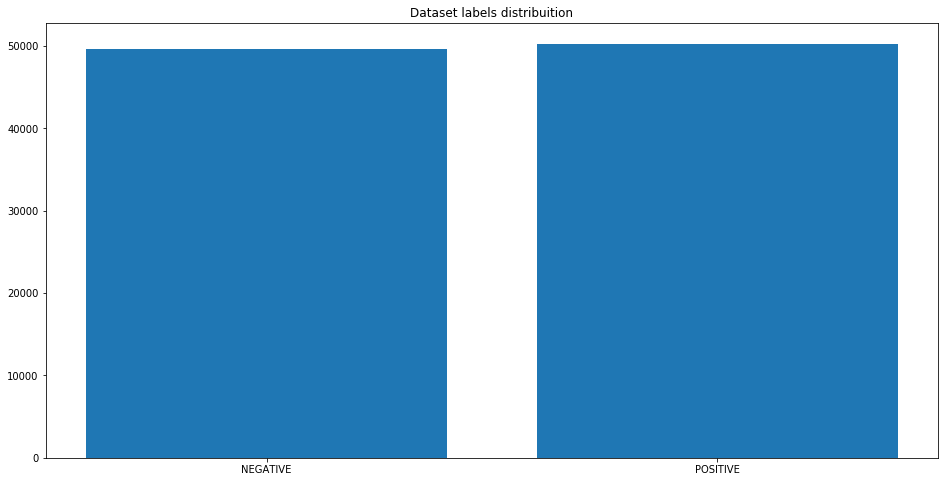

In [25]:
target_cnt = Counter(df.sentiment)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [175]:
stemmer = SnowballStemmer("english")

In [176]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [177]:
df.text = df.text.apply(lambda x: preprocess(x))


In [178]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1611
TEST size: 403


In [179]:
documents = [_text.split() for _text in df_train.text] 

In [180]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [181]:
w2v_model.build_vocab(documents)

In [182]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 204


In [183]:
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

(139446, 473984)

In [ ]:
w2v_model.most_similar("hate")

In [28]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 49632


In [ ]:
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

In [ ]:
labels = df_train.sentiment.unique().tolist()
labels.append(NEUTRAL)
labels

In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.sentiment.tolist())

y_train = encoder.transform(df_train.sentiment.tolist())
y_test = encoder.transform(df_test.sentiment.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

In [ ]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

In [ ]:
y_train[:10]

In [ ]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

In [ ]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [34]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=1024,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

In [ ]:
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [166]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [167]:
def predict(text, include_neutral=False):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [41]:
predict("I love the music",True)

{'elapsed_time': 0.22768783569335938,
 'label': 'POSITIVE',
 'score': 0.9934476017951965}

In [42]:
predict("I hate the rain")

{'elapsed_time': 0.047347307205200195,
 'label': 'NEGATIVE',
 'score': 0.0036625443026423454}

In [47]:
predict('I like houston!')

{'elapsed_time': 0.046098947525024414,
 'label': 'NEGATIVE',
 'score': 0.4560582637786865}

In [44]:
predict('golden warriors is the champion!')

{'elapsed_time': 0.04611611366271973,
 'label': 'POSITIVE',
 'score': 0.5537282824516296}

In [45]:
predict("i don't know what i'm doing",False)

{'elapsed_time': 0.04495382308959961,
 'label': 'NEGATIVE',
 'score': 0.3663935661315918}

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

In [162]:
del model

In [137]:
from keras.models import load_model
model = load_model('model.h5')

In [138]:
nba=pd.read_csv('nbalabeled.csv')

In [139]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [140]:
nba.sentiment = nba.sentiment.apply(lambda x: decode_sentiment(x))
nba.text = nba.text.apply(lambda x: preprocess(x))
nbadf_train, nbadf_test = train_test_split(nba, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(nbadf_train))
print("TEST size:", len(nbadf_test))

TRAIN size: 1611
TEST size: 403


Text(0.5,1,'Dataset labels distribuition')

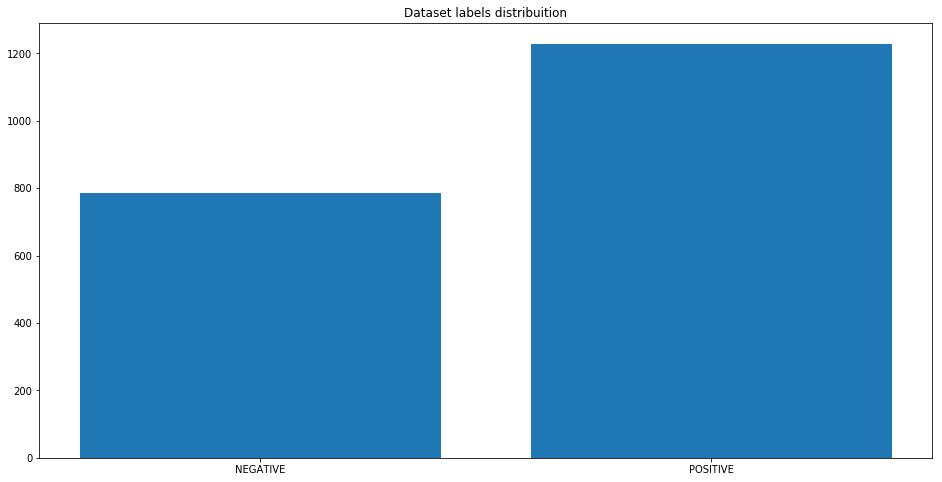

In [141]:
target_cnt = Counter(nba.sentiment)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [142]:
x_train = pad_sequences(tokenizer.texts_to_sequences(nbadf_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(nbadf_test.text), maxlen=SEQUENCE_LENGTH)

In [143]:
encoder = LabelEncoder()
encoder.fit(nbadf_train.sentiment.tolist())

y_train = encoder.transform(nbadf_train.sentiment.tolist())
y_test = encoder.transform(nbadf_test.sentiment.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [144]:
print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1611, 1)
y_test (403, 1)


In [145]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1611, 300)
y_train (1611, 1)

x_test (403, 300)
y_test (403, 1)


In [146]:
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=8,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 1449 samples, validate on 162 samples
Epoch 1/8
1449/1449 [==============================] - 16s 11ms/step - loss: 0.5909 - acc: 0.6784 - val_loss: 0.5125 - val_acc: 0.7284
Epoch 2/8
1449/1449 [==============================] - 12s 8ms/step - loss: 0.5571 - acc: 0.7143 - val_loss: 0.5146 - val_acc: 0.7407
Epoch 3/8
1449/1449 [==============================] - 11s 8ms/step - loss: 0.5380 - acc: 0.7226 - val_loss: 0.5101 - val_acc: 0.7469
Epoch 4/8
1449/1449 [==============================] - 11s 7ms/step - loss: 0.5183 - acc: 0.7315 - val_loss: 0.4725 - val_acc: 0.7654
Epoch 5/8
1449/1449 [==============================] - 11s 8ms/step - loss: 0.4958 - acc: 0.7591 - val_loss: 0.4483 - val_acc: 0.7593
Epoch 6/8
1449/1449 [==============================] - 10s 7ms/step - loss: 0.4756 - acc: 0.7709 - val_loss: 0.4464 - val_acc: 0.7840
Epoch 7/8
1449/1449 [==============================] - 11s 7ms/step - loss: 0.4703 - acc: 0.7757 - val_loss: 0.4483 - val_acc: 0.7840
Epoch 8/8
1449

In [147]:
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

403/403 [==============================] - 1s 3ms/step

ACCURACY: 0.7642679810523987
LOSS: 0.5076486468315125


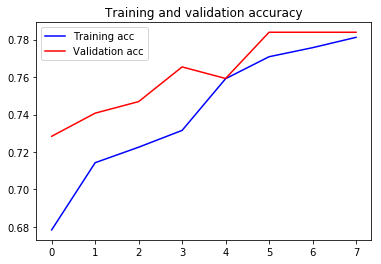

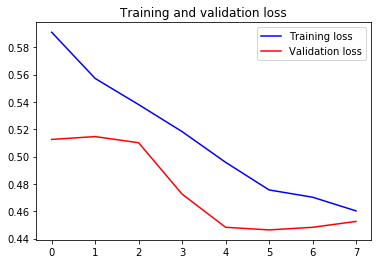

In [148]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [152]:
predict(' the other teams are all sucks ')

{'elapsed_time': 0.045143842697143555,
 'label': 'NEGATIVE',
 'score': 0.017229264602065086}

In [129]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [164]:
y_pred_1d = []
y_test_1d = list(nbadf_test.sentiment)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

3209/3209 [==============================] - 12s 4ms/step


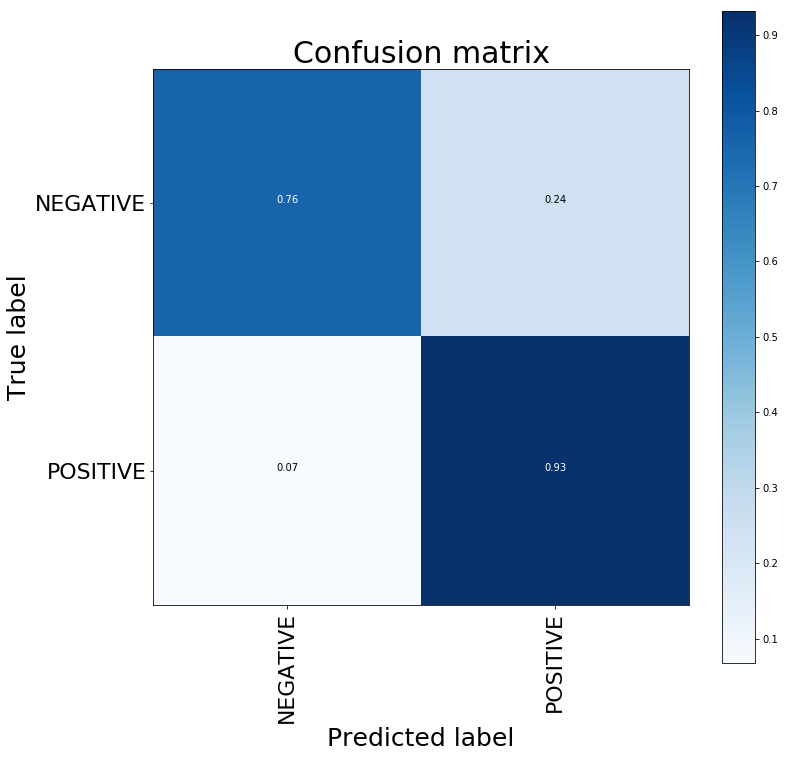

In [165]:
import numpy as np
import itertools
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=nbadf_train.sentiment.unique(), title="Confusion matrix")
plt.show()

In [153]:
model.save('MannualLabeled_Train.h5')

In [154]:
#Test the API_trained model on human labelled dataset
nba=pd.read_csv('API_data.csv')
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]
nba.sentiment = nba.sentiment.apply(lambda x: decode_sentiment(x))
nba.text = nba.text.apply(lambda x: preprocess(x))
nbadf_train, nbadf_test = train_test_split(nba, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(nbadf_train))
print("TEST size:", len(nbadf_test))
x_train = pad_sequences(tokenizer.texts_to_sequences(nbadf_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(nbadf_test.text), maxlen=SEQUENCE_LENGTH)
encoder = LabelEncoder()
encoder.fit(nbadf_train.sentiment.tolist())

y_train = encoder.transform(nbadf_train.sentiment.tolist())
y_test = encoder.transform(nbadf_test.sentiment.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

TRAIN size: 12832
TEST size: 3209
3209/3209 [==============================] - 7s 2ms/step

ACCURACY: 0.7320037400956538
LOSS: 0.5607925609065276


In [158]:
predict('refs are the mvp')

{'elapsed_time': 0.043235063552856445,
 'label': 'POSITIVE',
 'score': 0.5032122731208801}

In [136]:
del model

In [170]:
predict("“He makes me feel I could be in the NBA.”")

{'elapsed_time': 0.047566890716552734,
 'label': 'POSITIVE',
 'score': 0.574063241481781}

In [163]:
from keras.models import load_model
model = load_model('LSTM_API_Train.h5')

In [171]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          14889600  
_________________________________________________________________
dropout_3 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 15,050,101
Trainable params: 160,501
Non-trainable params: 14,889,600
_________________________________________________________________
